In [48]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import PIL.Image as Image

from skimage import io, color, transform
from skimage.feature import hog

import time

In [49]:
images = np.load('images.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)

df = pd.DataFrame({'gray_matrix': images.tolist(), 'label': labels.tolist()})
df

,gray_matrix,label
0,"[[46, 34, 26, 23, 12, 32, 35, 26, 26, 38, 71, ...",angry
1,"[[55, 33, 54, 32, 26, 21, 50, 29, 38, 45, 79, ...",angry
2,"[[123, 123, 126, 131, 124, 69, 109, 149, 159, ...",angry
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",angry
4,"[[127, 121, 124, 137, 123, 118, 120, 111, 111,...",angry
...,...,...
35882,"[[27, 26, 26, 26, 27, 27, 28, 28, 33, 34, 35, ...",surprise
35883,"[[7, 6, 13, 39, 76, 58, 29, 21, 16, 20, 34, 56...",surprise
35884,"[[124, 129, 125, 123, 129, 128, 127, 128, 131,...",surprise
35885,"[[242, 242, 242, 216, 110, 42, 20, 41, 37, 14,...",surprise


In [50]:
df

,gray_matrix,label
0,"[[46, 34, 26, 23, 12, 32, 35, 26, 26, 38, 71, ...",angry
1,"[[55, 33, 54, 32, 26, 21, 50, 29, 38, 45, 79, ...",angry
2,"[[123, 123, 126, 131, 124, 69, 109, 149, 159, ...",angry
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",angry
4,"[[127, 121, 124, 137, 123, 118, 120, 111, 111,...",angry
...,...,...
35882,"[[27, 26, 26, 26, 27, 27, 28, 28, 33, 34, 35, ...",surprise
35883,"[[7, 6, 13, 39, 76, 58, 29, 21, 16, 20, 34, 56...",surprise
35884,"[[124, 129, 125, 123, 129, 128, 127, 128, 131,...",surprise
35885,"[[242, 242, 242, 216, 110, 42, 20, 41, 37, 14,...",surprise


## Función para Hog descriptor

In [51]:
def calculate_hog(image):
    # Reshape de la imagen al tamaño requerido por HOG
    image_resized = cv2.resize(image, (64, 128))

    # Crear un objeto HOG
    hog = cv2.HOGDescriptor()

    # Calcular el HOG en la imagen redimensionada
    hog_features = hog.compute(image_resized)
    return hog_features

In [52]:
%%time

df['hog'] = df['gray_matrix'].apply(calculate_hog)
df

CPU times: total: 5.42 s
Wall time: 5.59 s


,gray_matrix,label,hog
0,"[[46, 34, 26, 23, 12, 32, 35, 26, 26, 38, 71, ...",angry,"[0.33274356, 0.1704117, 0.025357863, 0.0006549..."
1,"[[55, 33, 54, 32, 26, 21, 50, 29, 38, 45, 79, ...",angry,"[0.27381572, 0.22986299, 0.09233569, 0.0294371..."
2,"[[123, 123, 126, 131, 124, 69, 109, 149, 159, ...",angry,"[0.34384748, 0.01883176, 0.004236705, 0.010840..."
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",angry,"[0.014489936, 0.008741817, 0.020611065, 0.0, 0..."
4,"[[127, 121, 124, 137, 123, 118, 120, 111, 111,...",angry,"[0.25325525, 0.0767658, 0.026558537, 0.0181144..."
...,...,...,...
35882,"[[27, 26, 26, 26, 27, 27, 28, 28, 33, 34, 35, ...",surprise,"[0.14022486, 0.07403437, 0.0686184, 0.0, 0.041..."
35883,"[[7, 6, 13, 39, 76, 58, 29, 21, 16, 20, 34, 56...",surprise,"[0.39263126, 0.11640715, 0.0072888294, 0.00144..."
35884,"[[124, 129, 125, 123, 129, 128, 127, 128, 131,...",surprise,"[0.20560372, 0.04748373, 0.03934206, 0.0998374..."
35885,"[[242, 242, 242, 216, 110, 42, 20, 41, 37, 14,...",surprise,"[0.3589315, 0.16316827, 0.042510495, 0.0318309..."


In [53]:
X = np.array(df['hog'].values.tolist())
y = df['label']

# Undersampling

In [54]:
from sklearn.neighbors import NearestNeighbors
def knn_und(X,y,majority_class, k, t, algorithm="auto", metric="euclidean"):
    """Implementation of KNN Undersampling method for class undsersampling adjustment.

    Parameters
    ----------
    X : array-like, or pandas.DataFrame, shape (n_samples, n_features)
    Represents the data to be searched.

    Y :  array-like, or pandas.DataFrame, shape (n_samples, 1)
    The labels to X.

    k : optional int
    The number of nearest neighbors.

    t : optional int
    The threshold number of minority neighbors in order a majority example
    to be considered a noise, and marked to be removed.

    Returns
    -------
    undersampling_flags : ndarray, boolean, shape (n_samples, 1)
    Indicates with True/False if an example will be not removed/removed, given the developed
    heuristic.

    Reference
    ---------
    Beckmann, M., Ebecken, N.F.F.,de Lima, B.S.L.B.P. 2015, A KNN Undersampling Approach for Data Balancing,
    JILSA - Journal of Intelligent Learning Systems and Applications, 2015, 7, 104-116.

    """
    #TODO IMPLEMENT SUPPORT FOR SPARSE MATRICES
    if not isinstance(X, (np.ndarray, np.generic) ):
        X = np.asarray(X)

    if not isinstance(y, (np.ndarray, np.generic) ):
        y = np.asarray(y)



    nrows = X.shape[0]
    ncols=1

    result= [True] * nrows

    nbrs = NearestNeighbors(n_neighbors=k,algorithm="auto", metric=metric).fit(X)
    nns_indexes = nbrs.kneighbors(X,return_distance=False)

    for i in range(nrows):
        example = X[i,1:ncols]
        current_label = y[i]

        if (current_label != majority_class):
            result[i]=True
            continue

        nns_labels=y[nns_indexes[i]]

        num_of_minority = 0

        for nn_label in nns_labels:
            if nn_label==i:
                continue

            if nn_label!=majority_class:
                num_of_minority = num_of_minority+1


        if num_of_minority>t:
            result[i]=False
        else:
            result[i]=True

    return(result)

In [55]:
df.groupby('label').count()

,gray_matrix,hog
label,,
angry,4953,4953
disgust,547,547
fear,5121,5121
happy,8989,8989
neutral,6198,6198
sad,6077,6077
surprise,4002,4002


In [56]:
%%time
surprise=knn_und(X,y,'surprise', k=15, t=3, algorithm="auto", metric="euclidean")
surprise.count(False)

CPU times: total: 4min 20s
Wall time: 55.1 s


3396

In [57]:
%%time
angry=knn_und(X,y,'angry', k=15, t=7, algorithm="auto", metric="euclidean")
angry.count(False)

CPU times: total: 4min 29s
Wall time: 55.3 s


4390

In [58]:
%%time
fear=knn_und(X,y,'fear', k=15, t=8, algorithm="auto", metric="euclidean")
fear.count(False)

CPU times: total: 4min 27s
Wall time: 56.4 s


4386

In [59]:
%%time
sad=knn_und(X,y,'sad', k=19, t=10, algorithm="auto", metric="euclidean")
sad.count(False)

CPU times: total: 4min 24s
Wall time: 56.6 s


5491

In [60]:
%%time
neutral=knn_und(X,y,'neutral', k=15, t=5, algorithm="auto", metric="euclidean")
neutral.count(False)

CPU times: total: 4min 29s
Wall time: 57.5 s


5423

In [61]:
%%time
happy=knn_und(X,y,'happy', k=25, t=3, algorithm="auto", metric="euclidean")
happy.count(False)

CPU times: total: 3min 53s
Wall time: 1min 3s


8190

In [63]:
estados = [a*b*c*d*e*f for a,b,c,d,e,f in zip(happy,neutral,sad,fear,angry,surprise)]
df['estados']=estados
train=df[df['estados']!=0]
test=df[df['estados']!=1]

In [64]:
df.groupby('label').count()

,gray_matrix,hog,estados
label,,,
angry,4953,4953,4953
disgust,547,547,547
fear,5121,5121,5121
happy,8989,8989,8989
neutral,6198,6198,6198
sad,6077,6077,6077
surprise,4002,4002,4002


In [65]:
X_train=np.array(train['hog'].values.tolist())
y_train=train['label']
X_test=np.array(test['hog'].values.tolist())
y_test=test['label']

# Comparación inicial de modelos

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

In [68]:
# Definimos el pool de algoritmos de ensamble a evaluar
algos = []
algos.append(('RandomForest', RandomForestClassifier()))
algos.append(('Neural Network',MLPClassifier()))
algos.append(('KNN',KNeighborsClassifier()))

## Correlo cuando no estes haciendo nada ubu '3'

In [36]:
%%time
# Evaluamos cada algoritmo en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
kfold = KFold(n_splits=10, random_state=42, shuffle= True)  # especifica el particionador de datos a 10-folds CV

for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

RandomForest: 0.8107421644868623 (0.010822727577633473)
Neural Network: 0.8356906150583244 (0.014778036031122111)
KNN: 0.8367554789678332 (0.025926827740990283)
CPU times: total: 19min 47s
Wall time: 8min 41s


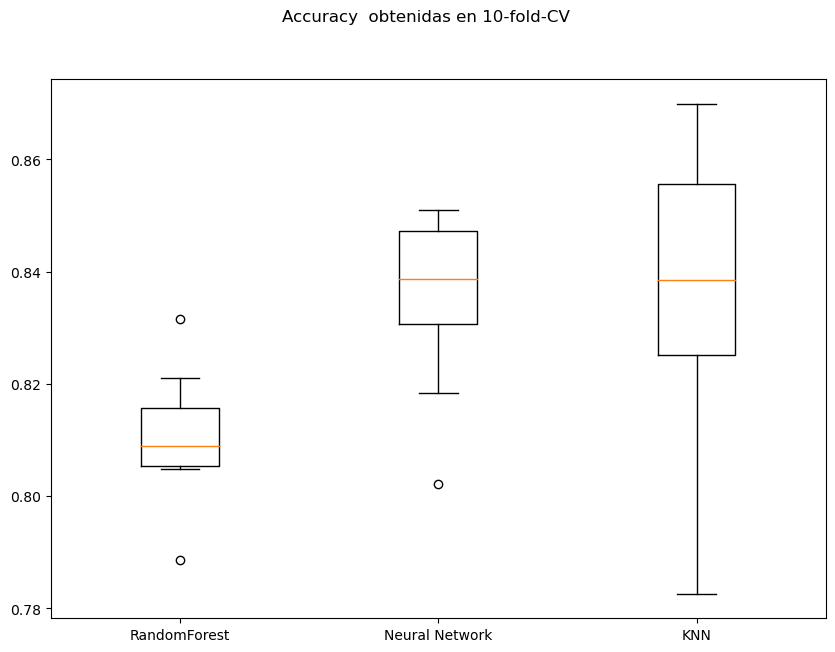

In [37]:
fig = plt.figure(figsize=[10,7])
fig.suptitle('Accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Entrenamiento Random Forest

In [38]:
%%time
# Crear el modelo
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_classifier.fit(X_train, y_train)

CPU times: total: 35.2 s
Wall time: 37.3 s


RandomForestClassifier(random_state=42)

In [39]:
y_pred_e= rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_e)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_train, y_pred_e))

Precisión del modelo: 1.0
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       445
     disgust       1.00      1.00      1.00       425
        fear       1.00      1.00      1.00       598
       happy       1.00      1.00      1.00       643
     neutral       1.00      1.00      1.00       620
         sad       1.00      1.00      1.00       479
    surprise       1.00      1.00      1.00       478

    accuracy                           1.00      3688
   macro avg       1.00      1.00      1.00      3688
weighted avg       1.00      1.00      1.00      3688



In [40]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Precisión del modelo: 0.7908992416034669
              precision    recall  f1-score   support

       angry       0.94      0.64      0.76       118
     disgust       0.86      0.56      0.68       122
        fear       0.65      0.74      0.69       137
       happy       0.84      1.00      0.91       156
     neutral       0.82      0.85      0.83       155
         sad       0.61      0.78      0.69       107
    surprise       0.91      0.90      0.90       128

    accuracy                           0.79       923
   macro avg       0.80      0.78      0.78       923
weighted avg       0.81      0.79      0.79       923



# Optimización de Hiperparámetros (GridSearch)

In [41]:
%%time
from sklearn.model_selection import GridSearchCV

# Define el modelo de Random Forest
rf_classifier = RandomForestClassifier()

# Define una cuadrícula de hiperparámetros que deseas explorar
param_grid = {
    'n_estimators': [150,200,250,300],        # Número de árboles en el bosque
    'max_depth': [10,20,30],      # Profundidad máxima de los árboles
    'min_samples_split': [10,20,30],     # Mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [10,20,30]       # Mínimo de muestras requeridas en una hoja
}

# Realiza la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=10,n_jobs=8)
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrena el modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

# Evalúa el modelo en el conjunto de prueba
y_pred = best_rf_classifier.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150}
Precisión del modelo: 0.7746478873239436
              precision    recall  f1-score   support

       angry       0.89      0.60      0.72       118
     disgust       0.88      0.47      0.61       122
        fear       0.66      0.77      0.71       137
       happy       0.82      0.99      0.90       156
     neutral       0.78      0.86      0.82       155
         sad       0.62      0.76      0.68       107
    surprise       0.89      0.88      0.88       128

    accuracy                           0.77       923
   macro avg       0.79      0.76      0.76       923
weighted avg       0.79      0.77      0.77       923

CPU times: total: 1min 14s
Wall time: 55min 32s


# Redes Neuronales

In [42]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=250, random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=250, random_state=42)

In [43]:
y_pred_e= mlp.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_e)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_train, y_pred_e))

Precisión del modelo: 1.0
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       445
     disgust       1.00      1.00      1.00       425
        fear       1.00      1.00      1.00       598
       happy       1.00      1.00      1.00       643
     neutral       1.00      1.00      1.00       620
         sad       1.00      1.00      1.00       479
    surprise       1.00      1.00      1.00       478

    accuracy                           1.00      3688
   macro avg       1.00      1.00      1.00      3688
weighted avg       1.00      1.00      1.00      3688



In [44]:
# Realizar predicciones en el conjunto de prueba
y_pred = mlp.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Precisión del modelo: 0.8136511375947996
              precision    recall  f1-score   support

       angry       0.83      0.74      0.78       118
     disgust       0.66      0.70      0.68       122
        fear       0.69      0.76      0.72       137
       happy       0.97      0.97      0.97       156
     neutral       0.91      0.88      0.89       155
         sad       0.67      0.66      0.67       107
    surprise       0.91      0.91      0.91       128

    accuracy                           0.81       923
   macro avg       0.81      0.80      0.80       923
weighted avg       0.82      0.81      0.81       923



# KNN

In [45]:
knn = KNeighborsClassifier(n_neighbors=5)  # Cambia 5 por el número de vecinos que desees utilizar
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [46]:
y_pred_e= knn.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_e)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_train, y_pred_e))

Precisión del modelo: 0.9113340563991323
              precision    recall  f1-score   support

       angry       0.89      0.95      0.92       445
     disgust       0.89      0.73      0.80       425
        fear       0.91      0.90      0.91       598
       happy       0.91      1.00      0.95       643
     neutral       0.90      0.98      0.94       620
         sad       0.96      0.79      0.87       479
    surprise       0.93      0.96      0.95       478

    accuracy                           0.91      3688
   macro avg       0.91      0.90      0.90      3688
weighted avg       0.91      0.91      0.91      3688



In [47]:
# Realizar predicciones en el conjunto de prueba
y_pred = knn.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Precisión del modelo: 0.8136511375947996
              precision    recall  f1-score   support

       angry       0.82      0.83      0.82       118
     disgust       0.78      0.50      0.61       122
        fear       0.69      0.85      0.76       137
       happy       0.84      1.00      0.91       156
     neutral       0.85      0.92      0.88       155
         sad       0.92      0.57      0.71       107
    surprise       0.85      0.91      0.88       128

    accuracy                           0.81       923
   macro avg       0.82      0.80      0.80       923
weighted avg       0.82      0.81      0.80       923

